<a href="https://colab.research.google.com/github/coco-in-bluemoon/three-minute-deep-learning-keras/blob/main/notebook/chapter7_1_gan_dnn_prob.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**데이터 관련 클래스**

In [1]:
import numpy as np

In [2]:
class Data:
    def __init__(self, mu, sigma, ni_D):
        self.real_sample = lambda n_batch: np.random.normal(mu, sigma, (n_batch, ni_D))
        self.in_sample = lambda n_batch: np.random.rand(n_batch, ni_D)

**머신 구현하기**

In [3]:
%matplotlib inline

In [4]:
import matplotlib.pyplot as plt

In [5]:
class Machine:
    def __init__(self, n_batch=10, ni_D=100):
        data_mean = 4
        data_stddev = 1.25

        self.n_iter_D = 1
        self.n_iter_G = 1

        self.data = Data(data_mean, data_stddev, ni_D)
        self.gan = GAN(ni_D=ni_D, nh_D = 50, nh_G=50)

        self.n_batch = n_batch
        self.ni_D = ni_D

    def train_D(self):
        gan = self.gan
        n_batch = self.n_batch
        data = self.data

        # Real Data (lambda)
        Real = data.real_sample(n_batch)

        # Generated Data (lambda)
        Z = data.in_sample(n_batch)
        Gen = gan.G.predict(Z)

        gan.D.trainable = True
        gan.D_train_on_batch(Real, Gen)

    def train_GD(self):
        gan = self.gan
        n_batch = self.n_batch
        data = self.data

        Z = data.in_sample(n_batch)

        gan.D.trainable = False
        gan.GD_train_on_batch(Z)

    def train_each(self):
        for it in range(self.n_iter_D):
            self.train_D()
        for it in range(self.n_iter_G):
            self.train_GD()

    def train(self, epochs):
        for epoch in range(epochs):
            self.train_each()

    def test(self, n_test):
        gan = self.gan
        data = self.data

        Z = data.in_sample(n_test)
        Gen = gan.G.predict(Z)
        return Gen, Z

    def show_hist(self, Real, Gen, Z):
        plt.hist(Real.reshape(-1), histtype='step', label='Real')
        plt.hist(Gen.reshape(-1), histtype='step', label='Generated')
        plt.hist(Z.reshape(-1), histtype='step', label='Input')
        plt.legend(loc=0)

    def test_and_show(self, n_test):
        data = self.data
        Gen, Z = self.test(n_test)
        Real = data.real_sample(n_test)

        self.show_hist(Real, Gen, Z)
        Machine.print_stat(Real, Gen)

    def run_epochs(self, epochs, n_test):
        self.train(epochs)
        self.test_and_show(n_test)

    def run(self, n_repeat=200, n_show=200, n_test=100):
        for ii in range(n_repeat):
            print('Stage', ii, '(Epoch: {})'.format(ii * n_show))
            self.run_epochs(n_show, n_test)
            plt.show()

    @staticmethod
    def print_stat(Real, Gen):
        def stat(d):
            return (np.mean(d), np.std(d))

        print('Mean and Std of Real:', stat(Real))
        print('Mean and Std of Gen:', stat(Gen))

**GAN 모델링**

In [6]:
from keras import backend as K
from keras import layers, models, optimizers

In [7]:
def add_decorate(x):
    m = K.mean(x, axis=-1, keepdims=True)
    d = K.square(x - m)

    return K.concatenate([x, d], axis=-1)

def add_decorate_shape(input_shape):
    shape = list(input_shape)
    assert len(shape) == 2

    shape[1] *= 2
    return tuple(shape)

In [8]:
lr = 2e-4
adam = optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999)

In [9]:
def model_compile(model):
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

In [10]:
class GAN:
    def __init__(self, ni_D, nh_D, nh_G):
        self.ni_D = ni_D
        self.nh_D = nh_D
        self.nh_G = nh_G

        self.D = self.gen_D()
        self.G = self.gen_G()
        self.GD = self.make_GD()

    def gen_D(self):
        ni_D = self.ni_D
        nh_D = self.nh_D

        D = models.Sequential()
        D.add(
            layers.Lambda(
                add_decorate, output_shape=add_decorate_shape, input_shape=(ni_D, )
            )
        )
        D.add(
            layers.Dense(nh_D, activation='relu')
        )
        D.add(
            layers.Dense(nh_D, activation='relu')
        )
        D.add(
            layers.Dense(1, activation='sigmoid')
        )

        model_compile(D)

        return D

    def gen_G(self):
        ni_D = self.ni_D
        nh_G = self.nh_G

        G = models.Sequential()
        G.add(
            layers.Reshape((ni_D, 1), input_shape=(ni_D, ))
        )
        G.add(
            layers.Conv1D(nh_G, 1, activation='relu')
        )
        G.add(
            layers.Conv1D(nh_G, 1, activation='sigmoid')
        )
        G.add(
            layers.Conv1D(1, 1)
        )
        G.add(
            layers.Flatten()
        )

        model_compile(G)
        return G

    def make_GD(self):
        G, D = self.G, self.D
        GD = models.Sequential()
        GD.add(G)
        GD.add(D)

        D.trainable = False
        model_compile(GD)
        D.trainable = True
        return GD

    def D_train_on_batch(self, Real, Gen):
        D = self.D
        X = np.concatenate([Real, Gen], axis=0)
        y = np.array([1] * Real.shape[0] + [0] * Gen.shape[0])
        D.train_on_batch(X, y)

    def GD_train_on_batch(self, Z):
        GD = self.GD
        y = np.array([1] * Z.shape[0])
        GD.train_on_batch(Z, y)

In [11]:
def main():
    machine = Machine(n_batch=10, ni_D=100)
    machine.run(n_repeat=200, n_show=200, n_test=100)

Stage 0 (Epoch: 0)
Mean and Std of Real: (4.009175570241712, 1.2415696466452244)
Mean and Std of Gen: (0.015542577, 0.06728099)


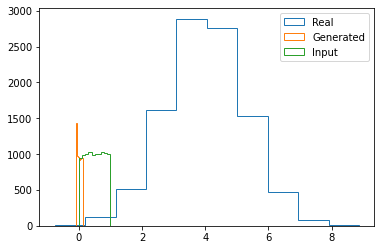

Stage 1 (Epoch: 200)
Mean and Std of Real: (3.998556582739217, 1.2424751587316212)
Mean and Std of Gen: (-0.07496716, 0.06379475)


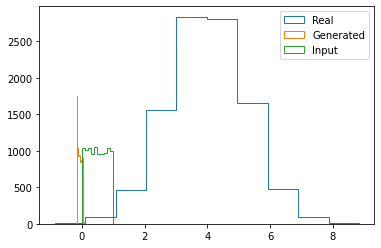

Stage 2 (Epoch: 400)
Mean and Std of Real: (3.9903120661369447, 1.2450745031108867)
Mean and Std of Gen: (0.9677846, 0.5916163)


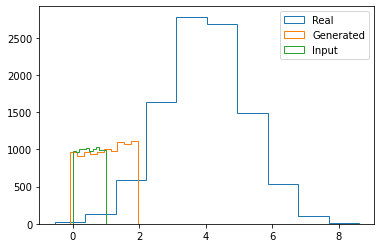

Stage 3 (Epoch: 600)
Mean and Std of Real: (3.9963286439053225, 1.241983131365308)
Mean and Std of Gen: (2.8995745, 0.9983172)


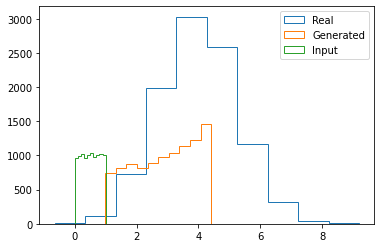

Stage 4 (Epoch: 800)
Mean and Std of Real: (4.0203439294892265, 1.237487906532887)
Mean and Std of Gen: (3.6968815, 1.244949)


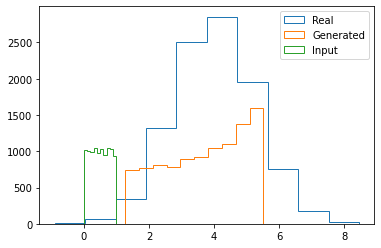

Stage 5 (Epoch: 1000)
Mean and Std of Real: (4.031266920983159, 1.2399374777655063)
Mean and Std of Gen: (4.4746757, 1.3931946)


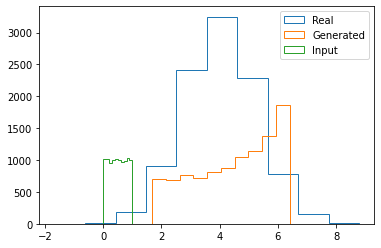

Stage 6 (Epoch: 1200)
Mean and Std of Real: (4.021338158008044, 1.2628704533876594)
Mean and Std of Gen: (5.0768366, 1.4883914)


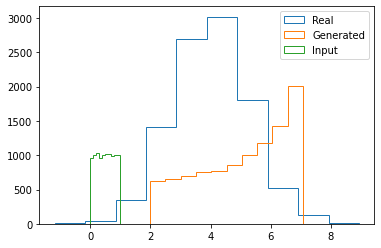

Stage 7 (Epoch: 1400)
Mean and Std of Real: (3.9910045128187783, 1.2370294925686363)
Mean and Std of Gen: (5.515604, 1.5634824)


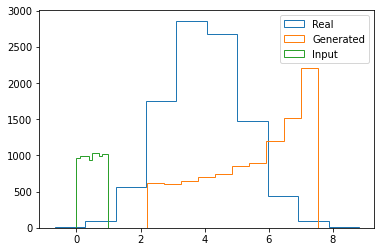

Stage 8 (Epoch: 1600)
Mean and Std of Real: (4.017282055956118, 1.2541457065758261)
Mean and Std of Gen: (5.758876, 1.5765722)


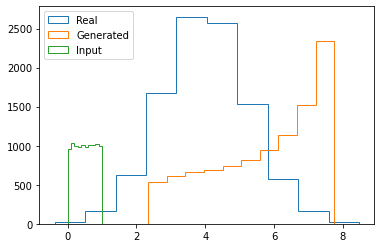

Stage 9 (Epoch: 1800)
Mean and Std of Real: (3.985774576935455, 1.2620973763585897)
Mean and Std of Gen: (5.8316493, 1.5797676)


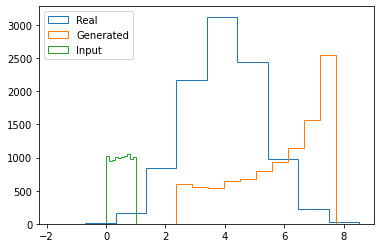

Stage 10 (Epoch: 2000)
Mean and Std of Real: (4.015633186679773, 1.2477920442788946)
Mean and Std of Gen: (5.5998883, 1.5613502)


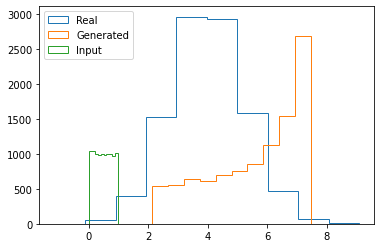

Stage 11 (Epoch: 2200)
Mean and Std of Real: (3.9847899967628306, 1.2379340014850073)
Mean and Std of Gen: (5.307333, 1.4847786)


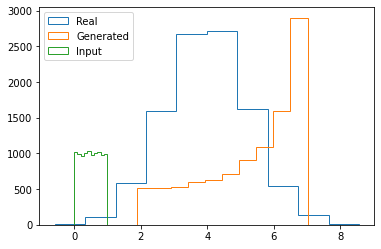

Stage 12 (Epoch: 2400)
Mean and Std of Real: (4.009955600215707, 1.2555104651302493)
Mean and Std of Gen: (4.8328915, 1.4216129)


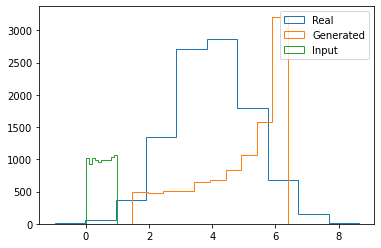

Stage 13 (Epoch: 2600)
Mean and Std of Real: (3.9822473560844105, 1.2419258453114532)
Mean and Std of Gen: (4.1974807, 1.3370956)


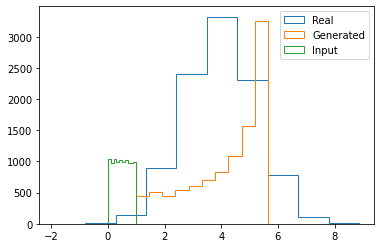

Stage 14 (Epoch: 2800)
Mean and Std of Real: (4.020709429279846, 1.2660885979808882)
Mean and Std of Gen: (3.7047613, 1.2446172)


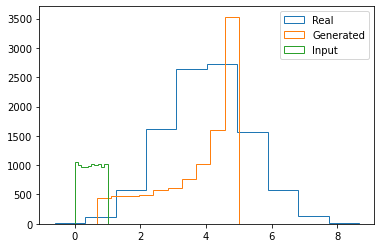

Stage 15 (Epoch: 3000)
Mean and Std of Real: (4.004438120494093, 1.25697140529407)
Mean and Std of Gen: (3.383496, 1.1207745)


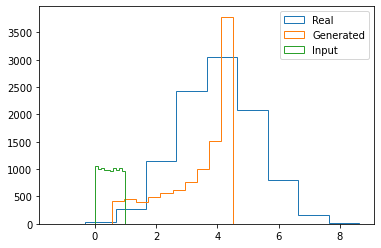

Stage 16 (Epoch: 3200)
Mean and Std of Real: (4.006535082472327, 1.2604537692331717)
Mean and Std of Gen: (3.3449445, 1.0292332)


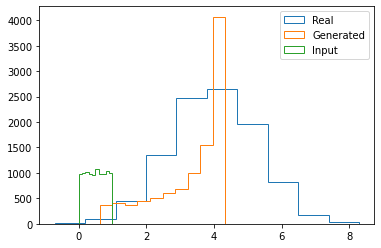

Stage 17 (Epoch: 3400)
Mean and Std of Real: (3.9994078140433413, 1.2465034777929342)
Mean and Std of Gen: (3.3251812, 1.0475348)


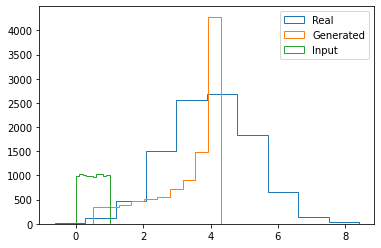

Stage 18 (Epoch: 3600)
Mean and Std of Real: (3.986057939657717, 1.2543933515334704)
Mean and Std of Gen: (3.5345695, 1.1106694)


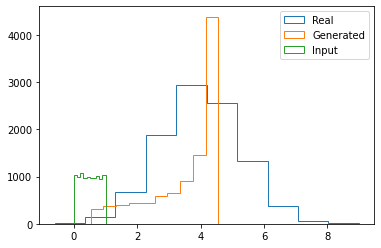

Stage 19 (Epoch: 3800)
Mean and Std of Real: (3.995024185086279, 1.2413825944880645)
Mean and Std of Gen: (3.9879766, 1.1582648)


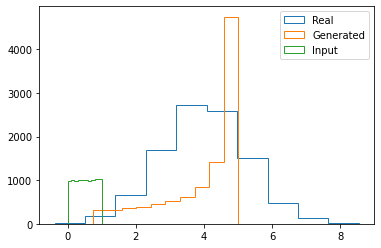

Stage 20 (Epoch: 4000)
Mean and Std of Real: (3.9931768968541057, 1.2479310992434365)
Mean and Std of Gen: (4.3751006, 1.2537559)


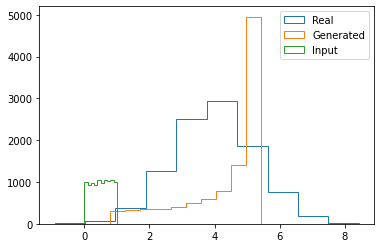

Stage 21 (Epoch: 4200)
Mean and Std of Real: (3.9873718231605118, 1.2348314806700427)
Mean and Std of Gen: (4.5475273, 1.375817)


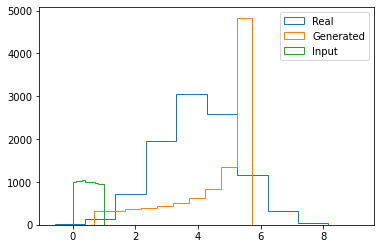

Stage 22 (Epoch: 4400)
Mean and Std of Real: (3.9948117570976285, 1.2489279707901777)
Mean and Std of Gen: (4.8413134, 1.3175309)


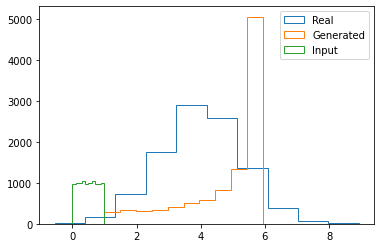

Stage 23 (Epoch: 4600)
Mean and Std of Real: (3.9865823458915495, 1.2401615126154726)
Mean and Std of Gen: (4.5550838, 1.3945062)


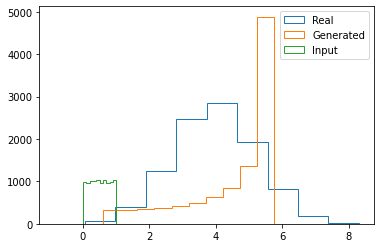

Stage 24 (Epoch: 4800)
Mean and Std of Real: (4.021577300122654, 1.2563966852638573)
Mean and Std of Gen: (4.393643, 1.2938586)


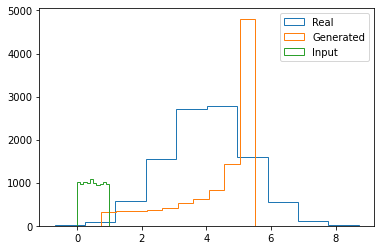

Stage 25 (Epoch: 5000)
Mean and Std of Real: (3.9946855292772163, 1.2444295988165825)
Mean and Std of Gen: (3.9055789, 1.2521818)


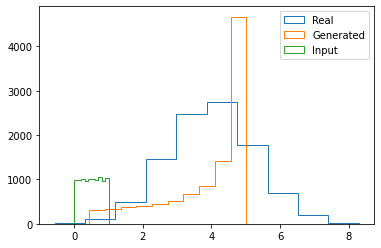

Stage 26 (Epoch: 5200)
Mean and Std of Real: (4.002245412024572, 1.2599262542302216)
Mean and Std of Gen: (3.6667473, 1.1807606)


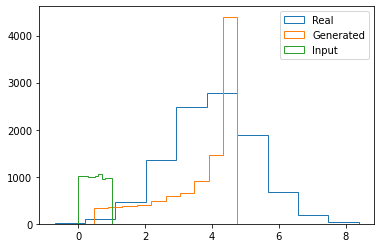

Stage 27 (Epoch: 5400)
Mean and Std of Real: (3.9886644489169325, 1.2415054574726494)
Mean and Std of Gen: (3.5792618, 1.1732613)


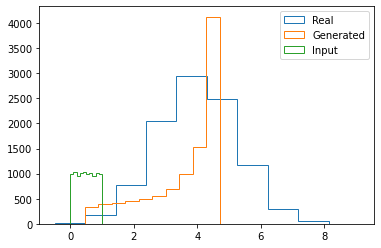

Stage 28 (Epoch: 5600)
Mean and Std of Real: (3.9861659521262003, 1.2558187297441175)
Mean and Std of Gen: (3.5691745, 1.178652)


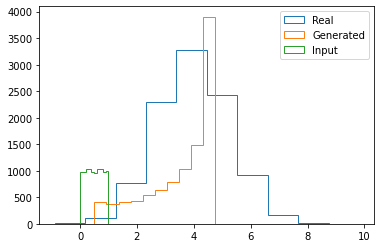

Stage 29 (Epoch: 5800)
Mean and Std of Real: (3.9927368614068577, 1.2377738646648107)
Mean and Std of Gen: (3.6262093, 1.2270491)


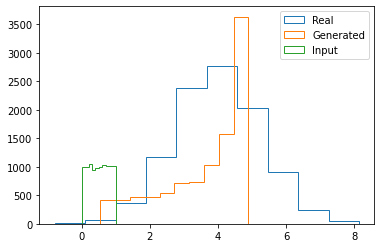

Stage 30 (Epoch: 6000)
Mean and Std of Real: (4.0142594150322815, 1.238277845307783)
Mean and Std of Gen: (3.7364566, 1.1962748)


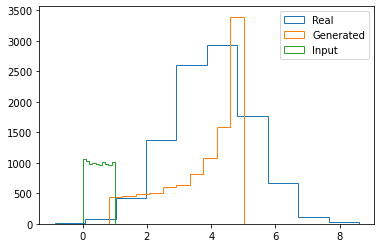

Stage 31 (Epoch: 6200)
Mean and Std of Real: (4.002306723197662, 1.2559110944037453)
Mean and Std of Gen: (3.5915685, 1.2347825)


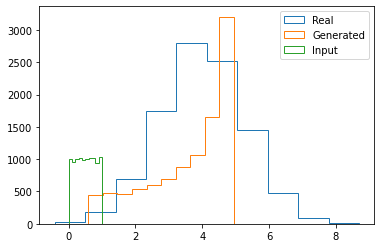

Stage 32 (Epoch: 6400)
Mean and Std of Real: (3.9928178809460735, 1.246182361207917)
Mean and Std of Gen: (3.8065898, 1.1658918)


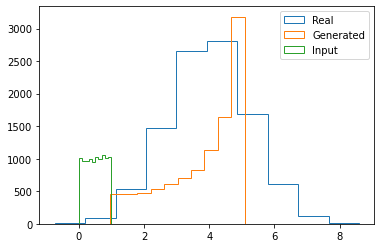

Stage 33 (Epoch: 6600)
Mean and Std of Real: (3.9762168806031113, 1.2563156550256873)
Mean and Std of Gen: (3.588764, 1.1937455)


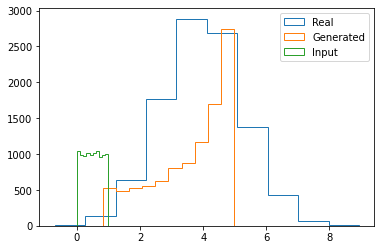

Stage 34 (Epoch: 6800)
Mean and Std of Real: (4.011809114136691, 1.2611036716549207)
Mean and Std of Gen: (3.3269012, 1.2527726)


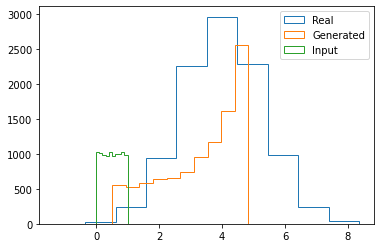

Stage 35 (Epoch: 7000)
Mean and Std of Real: (4.000750637647104, 1.244868147245897)
Mean and Std of Gen: (3.544865, 1.1993161)


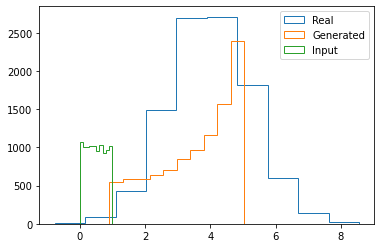

Stage 36 (Epoch: 7200)
Mean and Std of Real: (3.985953491401265, 1.2442572476877043)
Mean and Std of Gen: (3.8310962, 1.12005)


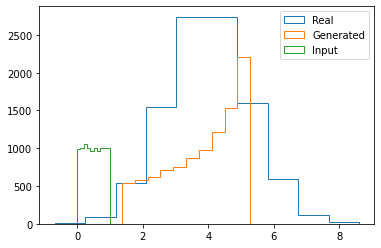

Stage 37 (Epoch: 7400)
Mean and Std of Real: (3.991580951414183, 1.2430230359979528)
Mean and Std of Gen: (3.7937763, 1.0858232)


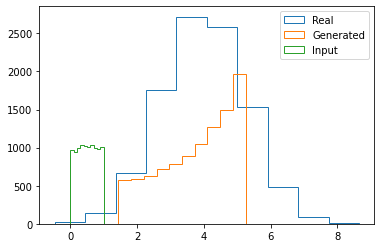

Stage 38 (Epoch: 7600)
Mean and Std of Real: (4.020321004723396, 1.2517023977861788)
Mean and Std of Gen: (3.646247, 1.0742564)


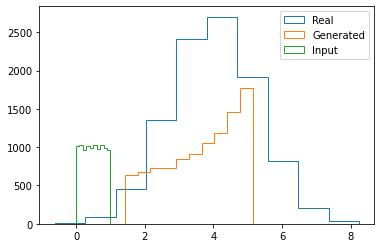

Stage 39 (Epoch: 7800)
Mean and Std of Real: (4.001866801710087, 1.250842075757407)
Mean and Std of Gen: (3.700736, 1.0636177)


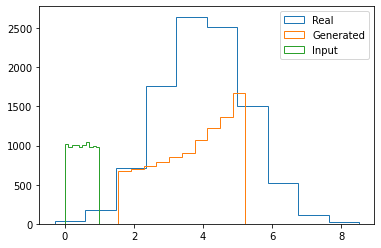

Stage 40 (Epoch: 8000)
Mean and Std of Real: (4.005398292690901, 1.2421901894277425)
Mean and Std of Gen: (3.745896, 1.0852326)


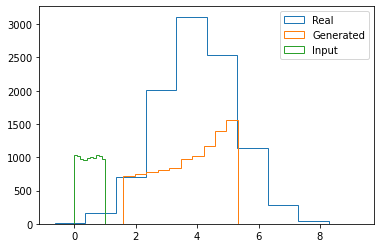

Stage 41 (Epoch: 8200)
Mean and Std of Real: (3.990192217601091, 1.235933592577675)
Mean and Std of Gen: (4.0095477, 1.0953863)


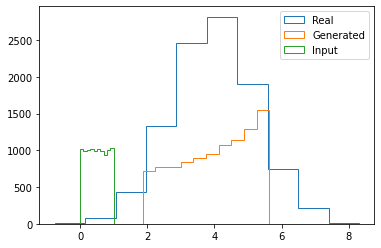

Stage 42 (Epoch: 8400)
Mean and Std of Real: (3.9917179716992788, 1.2616923369176472)
Mean and Std of Gen: (3.9756038, 1.11075)


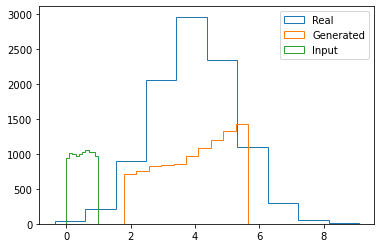

Stage 43 (Epoch: 8600)
Mean and Std of Real: (4.0052222623699105, 1.2504741793610576)
Mean and Std of Gen: (3.9468079, 1.1790961)


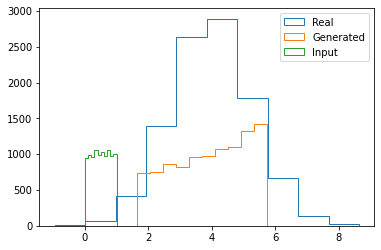

Stage 44 (Epoch: 8800)
Mean and Std of Real: (4.000853446114613, 1.2538406464192258)
Mean and Std of Gen: (3.8626227, 1.1512176)


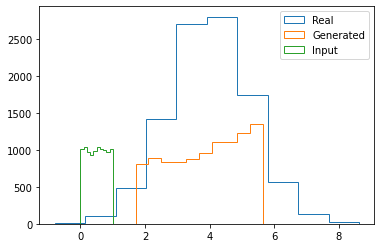

Stage 45 (Epoch: 9000)
Mean and Std of Real: (3.9955150109230964, 1.2527494211862418)
Mean and Std of Gen: (3.7811704, 1.1475676)


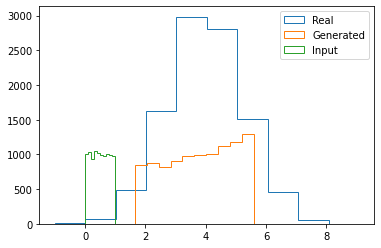

Stage 46 (Epoch: 9200)
Mean and Std of Real: (4.01239418812136, 1.247516703836115)
Mean and Std of Gen: (3.914273, 1.0705496)


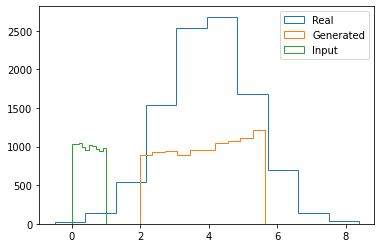

Stage 47 (Epoch: 9400)
Mean and Std of Real: (4.007851573954922, 1.2418657587395356)
Mean and Std of Gen: (4.1240377, 1.086573)


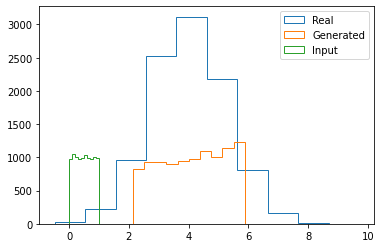

Stage 48 (Epoch: 9600)
Mean and Std of Real: (4.007229594143623, 1.2623746734471795)
Mean and Std of Gen: (4.143063, 1.1089733)


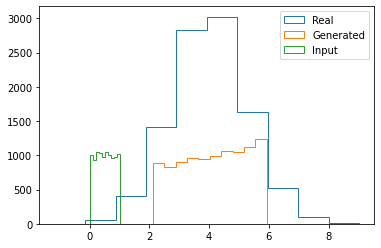

Stage 49 (Epoch: 9800)
Mean and Std of Real: (4.004630374105475, 1.2355875911954401)
Mean and Std of Gen: (3.9587195, 1.2047592)


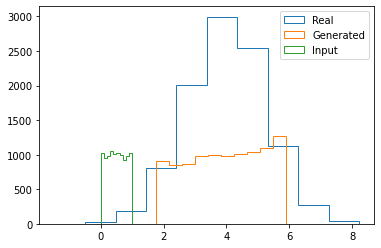

Stage 50 (Epoch: 10000)
Mean and Std of Real: (3.996779623398675, 1.2505021929289395)
Mean and Std of Gen: (3.9248464, 1.2093134)


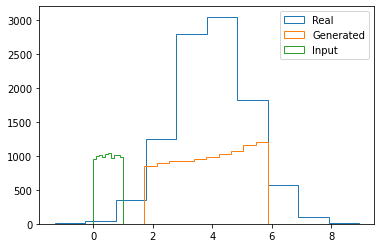

Stage 51 (Epoch: 10200)
Mean and Std of Real: (4.01129678550948, 1.2446167306751978)
Mean and Std of Gen: (3.9033515, 1.217625)


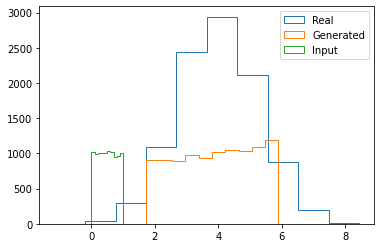

Stage 52 (Epoch: 10400)
Mean and Std of Real: (3.9862500061870154, 1.25827832546144)
Mean and Std of Gen: (3.881306, 1.1917887)


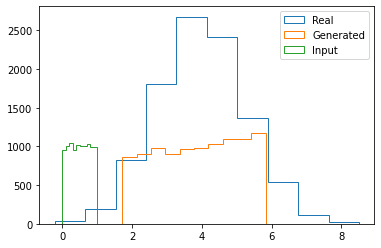

Stage 53 (Epoch: 10600)
Mean and Std of Real: (3.9886747761439736, 1.2528653639533327)
Mean and Std of Gen: (3.821507, 1.2931715)


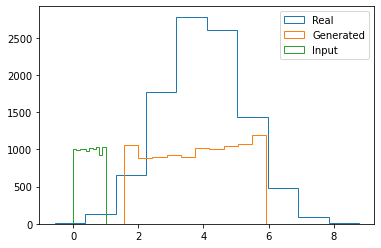

Stage 54 (Epoch: 10800)
Mean and Std of Real: (3.9976045968226797, 1.242261186935481)
Mean and Std of Gen: (4.019021, 1.1101198)


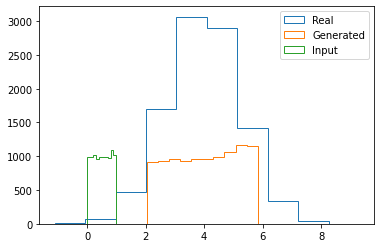

Stage 55 (Epoch: 11000)
Mean and Std of Real: (3.9799429034435785, 1.2447778694954317)
Mean and Std of Gen: (4.011271, 1.1336743)


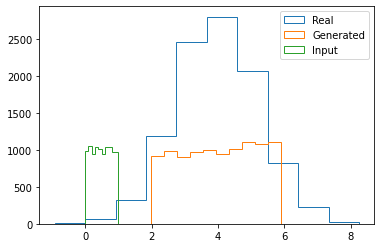

Stage 56 (Epoch: 11200)
Mean and Std of Real: (3.990454433517004, 1.2531667102817141)
Mean and Std of Gen: (3.9523468, 1.3115009)


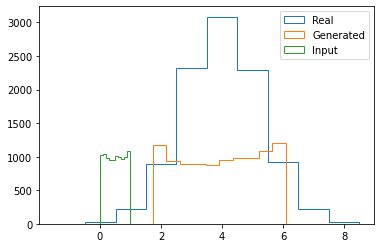

Stage 57 (Epoch: 11400)
Mean and Std of Real: (3.9814873553745485, 1.2579025029069417)
Mean and Std of Gen: (3.9198887, 1.3431752)


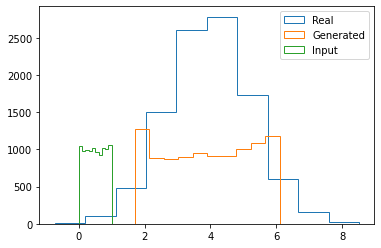

Stage 58 (Epoch: 11600)
Mean and Std of Real: (4.004553457937388, 1.2657002388987584)
Mean and Std of Gen: (3.9427269, 1.3487892)


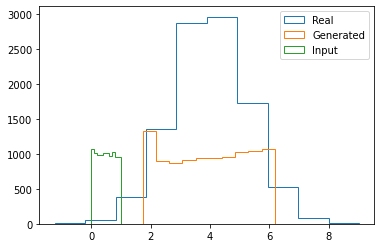

Stage 59 (Epoch: 11800)
Mean and Std of Real: (4.008967558867558, 1.2578274844042512)
Mean and Std of Gen: (3.9411345, 1.331956)


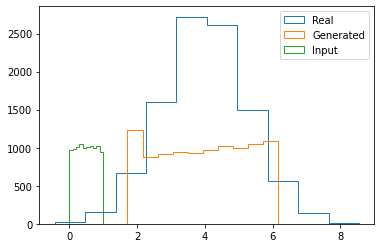

Stage 60 (Epoch: 12000)
Mean and Std of Real: (3.992698333914259, 1.2669055754822252)
Mean and Std of Gen: (3.971455, 1.3121716)


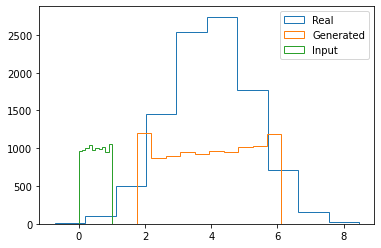

Stage 61 (Epoch: 12200)
Mean and Std of Real: (4.010085432060294, 1.2478491335879798)
Mean and Std of Gen: (3.9465652, 1.2339243)


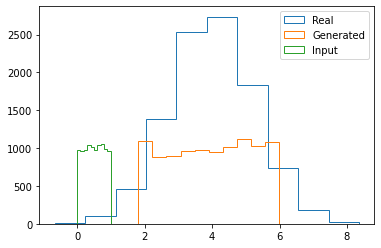

Stage 62 (Epoch: 12400)
Mean and Std of Real: (3.9860663331085364, 1.2541739358650552)
Mean and Std of Gen: (3.83303, 1.2244389)


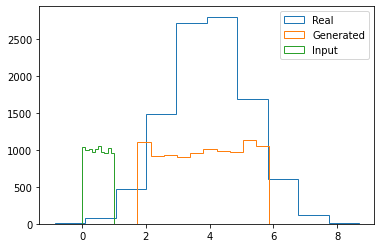

Stage 63 (Epoch: 12600)
Mean and Std of Real: (3.9884557887603878, 1.251866277359232)
Mean and Std of Gen: (3.9403472, 1.1659786)


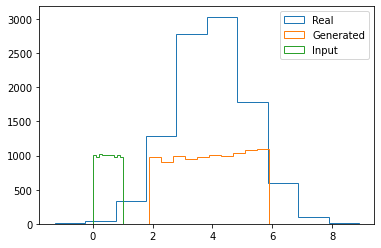

Stage 64 (Epoch: 12800)
Mean and Std of Real: (3.995002523891391, 1.2603721480233196)
Mean and Std of Gen: (4.0047736, 1.1620274)


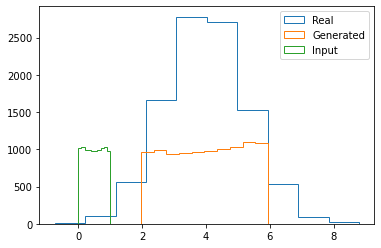

Stage 65 (Epoch: 13000)
Mean and Std of Real: (4.001312632669362, 1.2548102373237222)
Mean and Std of Gen: (3.8546586, 1.3177474)


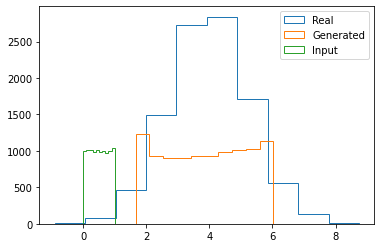

Stage 66 (Epoch: 13200)
Mean and Std of Real: (3.99828103578954, 1.2587073808875062)
Mean and Std of Gen: (4.0286064, 1.181756)


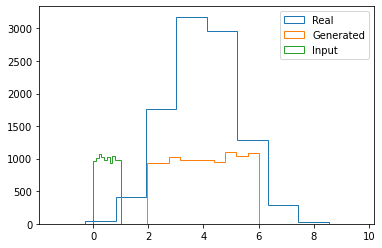

Stage 67 (Epoch: 13400)
Mean and Std of Real: (3.9853463044197137, 1.2408087244349055)
Mean and Std of Gen: (4.124343, 1.1506113)


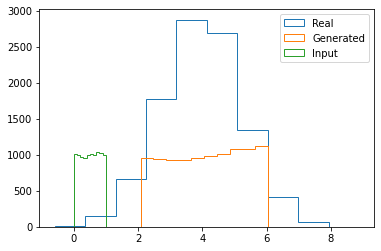

Stage 68 (Epoch: 13600)
Mean and Std of Real: (3.9990754009506926, 1.2455647307028865)
Mean and Std of Gen: (4.076457, 1.2671013)


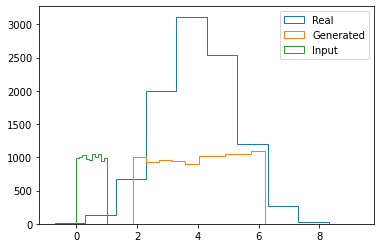

Stage 69 (Epoch: 13800)
Mean and Std of Real: (4.012653856335805, 1.2481636410892243)
Mean and Std of Gen: (3.940089, 1.4337442)


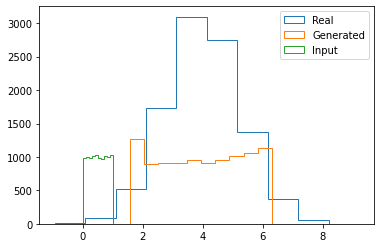

Stage 70 (Epoch: 14000)
Mean and Std of Real: (4.000833231772677, 1.2424767100430834)
Mean and Std of Gen: (4.214286, 1.274519)


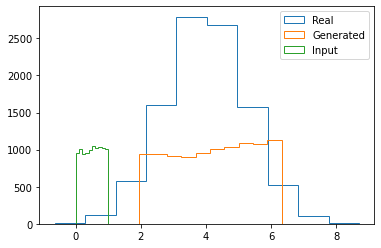

Stage 71 (Epoch: 14200)
Mean and Std of Real: (3.9925024541438003, 1.2472129614563112)
Mean and Std of Gen: (4.366397, 1.1178477)


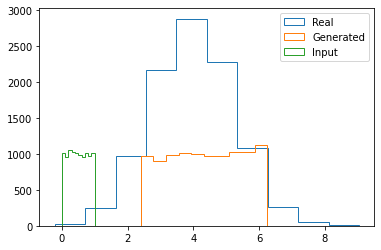

Stage 72 (Epoch: 14400)
Mean and Std of Real: (4.011791467757508, 1.2396338342880684)
Mean and Std of Gen: (4.071611, 1.2469968)


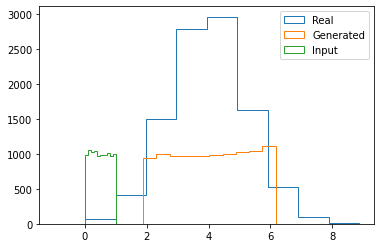

Stage 73 (Epoch: 14600)
Mean and Std of Real: (3.994673722781399, 1.2563522712973183)
Mean and Std of Gen: (3.8688657, 1.3788205)


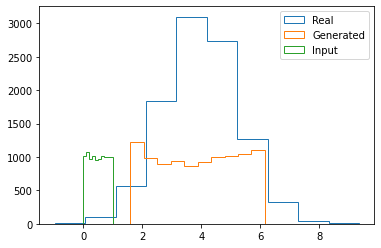

Stage 74 (Epoch: 14800)
Mean and Std of Real: (4.00413414999858, 1.2418845602450463)
Mean and Std of Gen: (3.8118062, 1.355566)


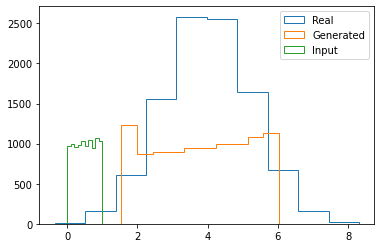

Stage 75 (Epoch: 15000)
Mean and Std of Real: (4.002762980988229, 1.249752880721651)
Mean and Std of Gen: (4.0346665, 1.1623889)


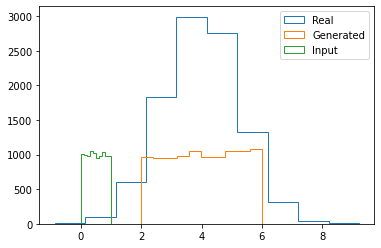

Stage 76 (Epoch: 15200)
Mean and Std of Real: (4.004508415670637, 1.2394432285565014)
Mean and Std of Gen: (4.133006, 1.0699184)


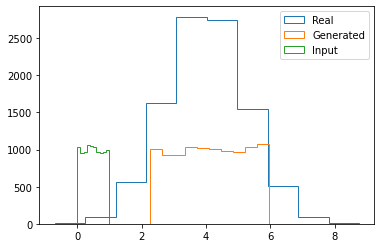

Stage 77 (Epoch: 15400)
Mean and Std of Real: (3.993719730949554, 1.2610120472909705)
Mean and Std of Gen: (3.9574358, 1.1993659)


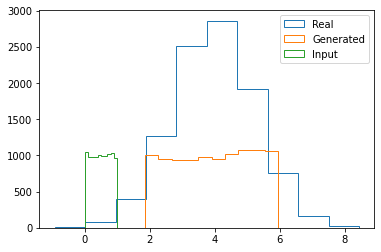

Stage 78 (Epoch: 15600)
Mean and Std of Real: (4.000007121690704, 1.264960985036603)
Mean and Std of Gen: (3.828885, 1.3205411)


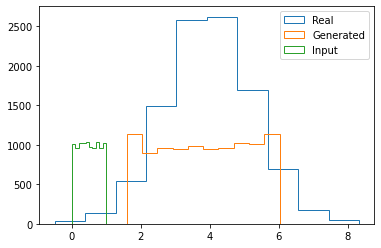

Stage 79 (Epoch: 15800)
Mean and Std of Real: (3.996421898746307, 1.231534131427831)
Mean and Std of Gen: (3.736431, 1.38123)


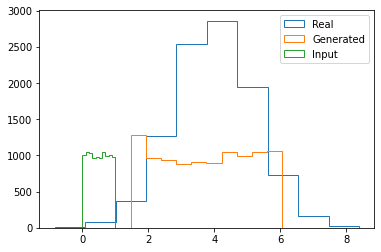

Stage 80 (Epoch: 16000)
Mean and Std of Real: (3.975732790995066, 1.250988511307916)
Mean and Std of Gen: (3.8839269, 1.2869618)


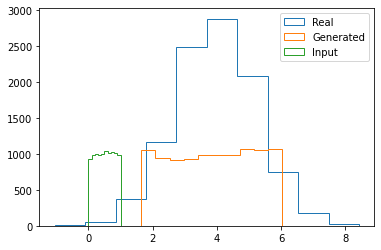

Stage 81 (Epoch: 16200)


KeyboardInterrupt: ignored

In [12]:
main()